In [1]:
import numpy as np
import sympy as sp
import sympy.physics.secondquant as sq
import matplotlib.pyplot as plt
import math
import itertools

# Parameters

### Conversions of different atom parameters sets conventions

_Conversion formula_ Racah params $A, B, C$ from $\{F_k\}$:
$$
\begin{pmatrix} A \\ B \\ C \end{pmatrix}
=
\begin{pmatrix} 1 & 0 & -7 \cdot 7 \\ 0 & 1 & -5 \\ 0 & 0 & +5 \cdot 7 \end{pmatrix}
\begin{pmatrix} F_0 \\ F_2 \\ F_4 \end{pmatrix}
$$
_Conversion formula_ $\{F_k\}$ params from $\{F^k\}$:
$$
\begin{pmatrix} F_0 \\ F_2 \\ F_4 \end{pmatrix}
=
\begin{pmatrix} F^0 \\ (7)^{-2} F^2 \\ (3\cdot 7)^{-2} F^4 \end{pmatrix}
$$

_Definition_ of $\{F^k\}$ params:
$$
F^k
=
\int_0^\infty
\int_0^\infty
~\frac{\big(\min(r_1, r_2)\big)^k}{\big(\max(r_1, r_2)\big)^{k+1}}
~R^2(r_1)
R^2(r_1)
~r_1^2
d r_1
~r_2^2
d r_1
$$
(here we assume all the relevant orbitals share the same radial function)

In [2]:
Fsub024_to_ABC_kernel = np.array([
    [1.0, 0.0, -7.0 * 7.0 ],
    [0.0, 1.0,       -5.0 ],
    [0.0, 0.0, +5.0 * 7.0 ],
])

def convert_Fsub024_to_ABC(Fsub0, Fsub2, Fsub4):
    Fsub024 = np.array([Fsub0, Fsub2, Fsub4])
    ABC = Fsub024_to_ABC_kernel @ Fsub024
    return [ABC[0], ABC[1], ABC[2]]

def convert_ABC_to_Fsub024(A, B, C):
    ABC = np.array([A, B, C])
    Fsub024 = np.linalg.inv(Fsub024_to_ABC_kernel) @ ABC
    return [Fsub024[0], Fsub024[1], Fsub024[2]]

def convert_Fsup024_to_Fsub024(Fsup0, Fsup2, Fsup4):
    return [Fsup0, 1 / 7**2 * Fsup2, 1 / (3 * 7)**2 * Fsup4]

def convert_Fsub024_to_Fsup024(Fsub0, Fsub2, Fsub4):
    return [Fsub0, 7**2 * Fsub2, (3 * 7)**2 * Fsub4]

## Parameters values - example

In [3]:
# For Ni(H2O)_6^2+:
A, B, C = 0, 930, 0 # A value does not matter here
# Dq = 850 # cm^-1
Dq = 200

# For Ni(NH3)_6^2+:
# A, B, C = 0, 881, 0
# Dq = 1075 # cm^-1

## Gaunt coefficients

$$
c^{(k)} (l m; l' m') =
\sqrt{\frac{4\pi}{2k + 1}}
\int_{0}^{2\pi} d\varphi
\int_{-1}^{1} dcos(\theta)
~Y_{l, m}^*(\theta, \varphi)
~Y_{k, m−m'} (\theta, \varphi)
~Y_{l', m'}(\theta, \varphi)
$$

In [4]:
# Hardcoded coefficients value l = l' = 2:

s5 = math.sqrt(5)
s6 = math.sqrt(6)
s15 = math.sqrt(15)
s30 = math.sqrt(30)
s35 = math.sqrt(35)
s40 = math.sqrt(40)
s70 = math.sqrt(70)

# c⁽⁰⁾(2, m; 2, m'):
c0 = np.array([
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 1.0]
])

# c⁽²⁾(2, m; 2, m'):
c2 = (
    1 / 7 *
    np.array([
        [  -2, +s6,  -2,   0,   0],
        [ -s6,  +1,  +1, -s6,   0],
        [  -2,  -1,  +2,  -1,  -2],
        [   0, -s6,  +1,  +1, -s6],
        [   0,   0,  -2, +s6,  -2]
    ])
)

# c⁽⁴⁾(2, m; 2, m'):
c4 = (
    1 / 3 / 7 *
    np.array([
        [+1.0,  -s5, +s15, -s35, +s70],
        [ +s5, -4.0, +s30, -s40, +s35],
        [+s15, -s30, +6.0, -s30, +s15],
        [+s35, -s40, +s30, -4.0,  +s5],
        [+s70, -s35, +s15,  -s5, +1.0]
    ])
)

# U2_over_F2 = 7**2 * np.outer(np.diag(c2), np.diag(c2))
# J2_over_F2 = 7**2 * c2 * c2 

# U4_over_F4 = (3 * 7)**2 * np.outer(np.diag(c4), np.diag(c4))
# J4_over_F4 = (3 * 7)**2 * c4 * c4

# Tanabe Sugano diagrams for $d^2$

In [5]:
lz_value_to_lz_idx_map = {-2: 0, -1: 1, 0: 2, +1: 3, +2: 4}
sz_value_to_sz_idx_map = {-0.5: 0, +0.5: 1}
to_spinorbial_index = lambda lz_value, sz_value: 1 + 2 * lz_value_to_lz_idx_map[lz_value] + sz_value_to_sz_idx_map[sz_value]
base_d2 = list(itertools.combinations(range(1, 11), r=2))
# ^^^We must start with 1, not with 0, to make `sympy` work well.

## Hamiltonians


For $d$ (l=2) shell with $n=3$ subscript supressed:
$$
H_{ee}
=
\frac{1}{2}
\sum_{m=2}^{2}
\sum_{\sigma}
\sum_{m'=2}^{2}
\sum_{\sigma'}
\sum_{k=0}^{2\cdot 2}
F^k
\sum_{\Delta m = -k}^k
(-1)^{\Delta m}
~
c^{(k)}\big(2,m + \Delta m; 2, m \big)
c^{(k)}\big(2,m' - \Delta m; 2, m' \big)
~
c_{m + \Delta m, \sigma}^\dagger
c_{m' - \Delta m, \sigma'}^\dagger
c_{m', \sigma'}
c_{m, \sigma}
$$

In [6]:
def build_H_ee(B, C_over_B=175/44):
    # Note: C_over_B = 175/44 ≃ 3.977 ensures Fsup4/Fsup2 = 15/23
    Fsub0, Fsub2, Fsub4 = convert_ABC_to_Fsub024(0, B, C_over_B * B)
    Fsup0, Fsup2, Fsup4 = convert_Fsub024_to_Fsup024(Fsub0, Fsub2, Fsub4)
    Fsup024 = {0: Fsup0, 2: Fsup2, 4: Fsup4}
    c024 = {0: c0, 2: c2, 4: c4}
    sym_H_ee = 0
    for lz_value in [+2, +1, 0, -1, -2]:
        for sz_value in [+0.5, -0.5]:
            for lz_value_prim in [+2, +1, 0, -1, -2]:
                for sz_value_prim in [+0.5, -0.5]:
                    contribution_ket = 0
                    for k in [2, 4]:
                        for lz_value_delta in range(-k, k + 1):
                            if not (-2 <= lz_value + lz_value_delta <= 2):
                                continue
                            if not (-2 <= lz_value_prim - lz_value_delta <= 2):
                                continue
                            contribution = 0.5 * Fsup024[k]
                            contribution *= (+1 if lz_value_delta % 2 == 0 else -1)
                            contribution *= c024[k][lz_value_to_lz_idx_map[lz_value + lz_value_delta], lz_value_to_lz_idx_map[lz_value]]
                            contribution *= c024[k][lz_value_to_lz_idx_map[lz_value_prim - lz_value_delta], lz_value_to_lz_idx_map[lz_value_prim]]
                            bra_1 = to_spinorbial_index(lz_value + lz_value_delta, sz_value)
                            bra_2 = to_spinorbial_index(lz_value_prim - lz_value_delta, sz_value_prim)
                            contribution_ket += contribution * sq.Fd(bra_1) * sq.Fd(bra_2)
                    ket_1 = to_spinorbial_index(lz_value, sz_value)
                    ket_2 = to_spinorbial_index(lz_value_prim, sz_value_prim)
                    sym_H_ee += contribution_ket * sq.F(ket_2) * sq.F(ket_1)

    num_H_ee = np.zeros((len(base_d2), len(base_d2)))
    for idx_ket, d2_ket in enumerate(base_d2):
        # print(f"aaa: {idx_ket}")
        ket_op = sq.Fd(d2_ket[1]) * sq.Fd(d2_ket[0])
        ket_state = sq.apply_operators(ket_op * sq.FKet([]))
        temp = sq.apply_operators(sym_H_ee * ket_state)
        # print(f"bbb: {idx_ket}")
        for idx_bra, d2_bra in enumerate(base_d2):
            # print(idx_bra, d2_bra, idx_ket, d2_ket)
            bra_op = sq.F(d2_bra[0]) * sq.F(d2_bra[1])
            bra_state = sq.apply_operators(sq.FBra([]) * bra_op)
            num_H_ee[idx_bra, idx_ket] = sq.apply_operators(bra_state * temp)

    return num_H_ee

In [33]:
# Hamiltonian for a unit value of ee selfinteraction (i.e. with B=1, C=15/23):
unit_H_ee = build_H_ee(B=1.0, C_over_B=4)
# unit_H_ee = build_H_ee(B=1.0)

$$
H_{cf} =
\sum_{\sigma}
\Bigg[
(6Dq)
\bigg[
~
c_{0, \sigma}^\dagger
c_{0, \sigma}
+
~
\frac{1}{2}
(c_{+2, \sigma}^\dagger + c_{-2, \sigma}^\dagger)
(c_{+2, \sigma} + c_{-2, \sigma})
\bigg]
-
(4Dq)
\bigg[
c_{-1, \sigma}^\dagger
c_{-1, \sigma}
+
~
c_{+1, \sigma}^\dagger
c_{+1, \sigma}
+
~
\frac{1}{2}
(c_{+2, \sigma}^\dagger - c_{-2, \sigma}^\dagger)
(c_{+2, \sigma} - c_{-2, \sigma})
\bigg]
\Bigg]
$$

In [ ]:
def build_H_cf(Dq):
    sym_H_cf = 0
    for sz_value in [+0.5, -0.5]:
        # 0 <-> 0:
        ket_1 = to_spinorbial_index(0, sz_value)
        bra_1 = to_spinorbial_index(0, sz_value)
        sym_H_cf += (6 * Dq) * sq.Fd(bra_1) * sq.F(ket_1)
        # +1 <-> +1:
        ket_1 = to_spinorbial_index(+1, sz_value)
        bra_1 = to_spinorbial_index(+1, sz_value)
        sym_H_cf += (-4 * Dq) * sq.Fd(bra_1) * sq.F(ket_1)
        # -1 <-> -1:
        ket_1 = to_spinorbial_index(-1, sz_value)
        bra_1 = to_spinorbial_index(-1, sz_value)
        sym_H_cf += (-4 * Dq) * sq.Fd(bra_1) * sq.F(ket_1)
        # +2 <-> +2:
        ket_1 = to_spinorbial_index(+2, sz_value)
        bra_1 = to_spinorbial_index(+2, sz_value)
        sym_H_cf += (1 * Dq) * sq.Fd(bra_1) * sq.F(ket_1)
        # -2 <-> -2:
        ket_1 = to_spinorbial_index(-2, sz_value)
        bra_1 = to_spinorbial_index(-2, sz_value)
        sym_H_cf += (1 * Dq) * sq.Fd(bra_1) * sq.F(ket_1)
        # +2 <-> -2:
        ket_1 = to_spinorbial_index(-2, sz_value)
        bra_1 = to_spinorbial_index(+2, sz_value)
        sym_H_cf += (5 * Dq) * sq.Fd(bra_1) * sq.F(ket_1)
        # -2 <-> +2:
        ket_1 = to_spinorbial_index(+2, sz_value)
        bra_1 = to_spinorbial_index(-2, sz_value)
        sym_H_cf += (5 * Dq) * sq.Fd(bra_1) * sq.F(ket_1)

    num_H_cf = np.zeros((len(base_d2), len(base_d2)))
    for idx_ket, d2_ket in enumerate(base_d2):
        ket_op = sq.Fd(d2_ket[1]) * sq.Fd(d2_ket[0])
        ket_state = sq.apply_operators(ket_op * sq.FKet([]))
        temp = sq.apply_operators(sym_H_cf * ket_state)
        for idx_bra, d2_bra in enumerate(base_d2):
            bra_op = sq.F(d2_bra[0]) * sq.F(d2_bra[1])
            bra_state = sq.apply_operators(sq.FBra([]) * bra_op)
            num_H_cf[idx_bra, idx_ket] = sq.apply_operators(bra_state * temp)

    return num_H_cf

In [ ]:
# Hamiltonian for a unit value of CF splitting (i.e. Dq=1)
unit_H_cf = build_H_cf(Dq=1.0)

## Exact numeric Diagonalization

(0.0, 45.0)

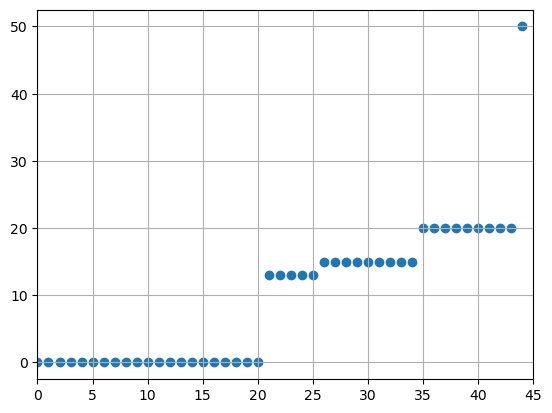

In [34]:
B, Dq = 1.0, 0.0
eigval, eigvec = np.linalg.eigh(B * unit_H_ee + Dq * unit_H_cf)

fig, ax = plt.subplots()
ax.scatter(range(len(eigval)), eigval - eigval[0])
ax.grid()
ax.set_xlim(0, len(eigval))

(0.0, 80.0)

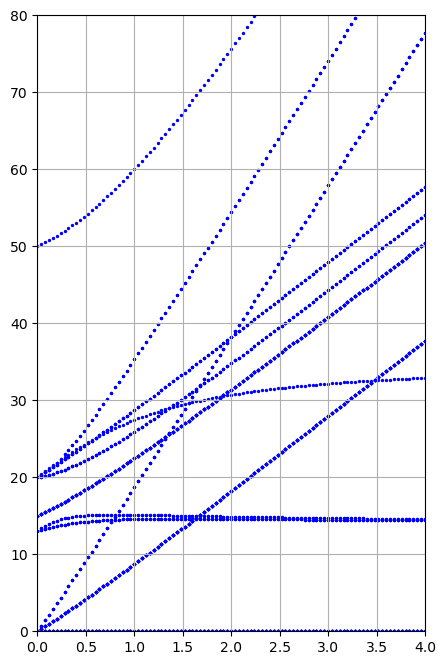

In [40]:
many_Dq_over_B = []
many_eigval = []
for Dq_over_B in np.linspace(0.0, 4.0, 101):
    eigval, eigvec = np.linalg.eigh(unit_H_ee + Dq_over_B * unit_H_cf)
    many_Dq_over_B.append(Dq_over_B)
    many_eigval.append(eigval - eigval[0])

fig, ax = plt.subplots(figsize=(5, 8))
for Dq_over_B, eigval in zip(many_Dq_over_B, many_eigval):
    ax.scatter([Dq_over_B] * len(eigval), eigval, color='b', s=2)
ax.grid()
ax.set_xlim(0, many_Dq_over_B[-1])
ax.set_ylim(0, 80)

<img src="wikipedia_tanabe_sugano_diagram_d2.svg.png" alt="drawing" width="400"/>

Ref: https://en.wikipedia.org/wiki/Tanabe%E2%80%93Sugano_diagram